# Imports

Steps to improve model:
1. Knowing this in Russia, add the bank and the school holidays
2. Add features that display the summer season, christmas and other important holidays or peak seasons in russia
3. check whether some items wherein specific discount and check sales relevant to them
4. Are same products sold for different prices in different stores
5. Price fluctuations over this period, does this affect the prcie?
6. How about stores that have closed, example shop 23

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor


In [72]:
train = pd.read_csv('Data/Grocery/sales_train.csv.gz')
shops = pd.read_csv('Data/Grocery/shops.csv')
items = pd.read_csv('Data/Grocery/items.csv')
test = pd.read_csv('Data/Grocery/test.csv.gz')
items_cats = pd.read_csv('Data/Grocery/item_categories.csv')
sub = pd.read_csv('Data/Grocery/sample_submission.csv.gz')

In [73]:
train['date'] = pd.to_datetime(train['date'], dayfirst=True)

In [74]:
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [107]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


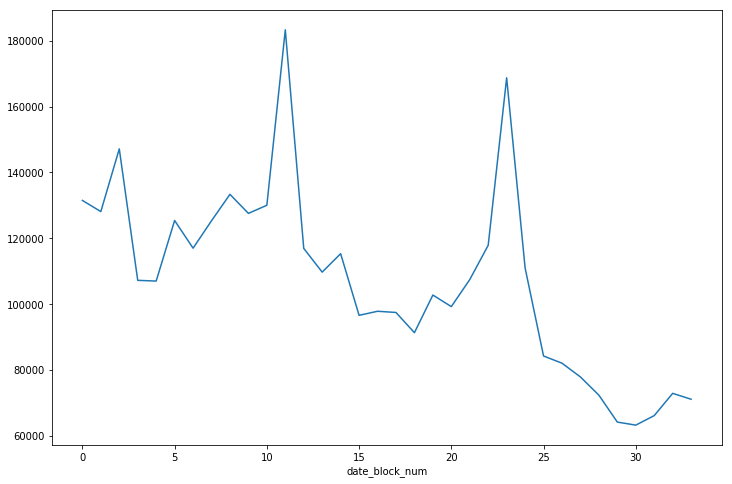

In [100]:
train.groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(12,8))

In [109]:
train['sales'] = train.item_price * train.item_cnt_day

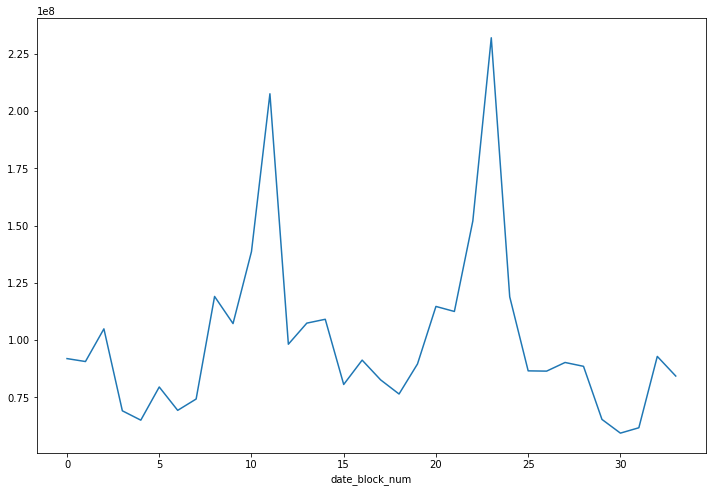

In [111]:
train.groupby('date_block_num')['sales'].sum().plot(figsize=(12,8))

At last a useful insight, although we see that the item count had dropped, there is an a totally difference in sales, although number of items in december dropped the sales increased

In [131]:
df = train.copy()

In [132]:
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year

In [136]:
year_1 = df[df.year == 2013]
year_2 = df[df.year == 2014]

In [149]:
year_1.sales.sum(),year_2.sales.sum()

(1217524733.9800026, 1346778478.8099935)

In [150]:
year_1.item_price.mean(),year_2.item_price.mean()

(726.7978012088336, 988.3442369568345)

It seems that this retailer has introduced some new items of high value which although sells more but pump up sales
Lets check how many new items has been intruduced in year 2, even better lets see how many items are introduced monthly

In [174]:
for i in range(0, 34):
    print(i, len(df[df.date_block_num == i].item_id.unique()))

0 8115
1 8168
2 8302
3 8145
4 8339
5 8478
6 8405
7 8031
8 7876
9 8039
10 8089
11 8474
12 7551
13 7134
14 7142
15 6774
16 6685
17 6681
18 6611
19 6363
20 6071
21 6334
22 6322
23 6605
24 6139
25 6053
26 6082
27 5476
28 5283
29 5216
30 5323
31 5108
32 5085
33 5413


The store is reducing the number of unique items, but still I need to know if new items are introduced

In [191]:
df['item_id'].unique()

array([22154,  2552,  2554, ...,  7610,  7635,  7640], dtype=int64)

In [27]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [62]:
df_train = train.copy()

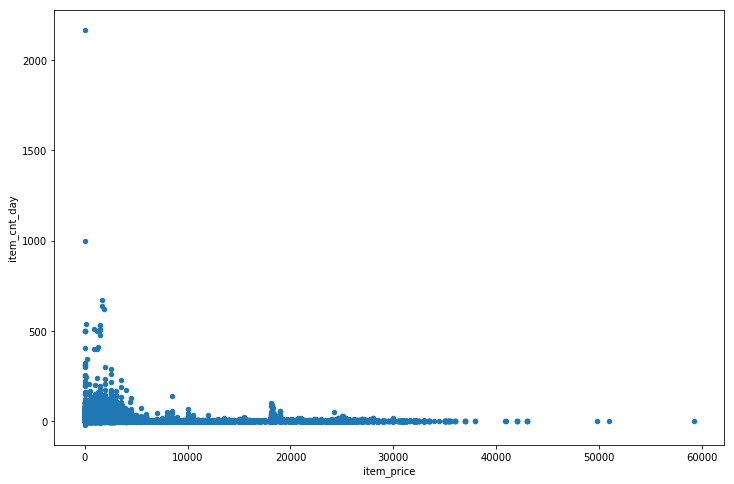

In [8]:
df_train[(train.item_price < 150000)].plot('item_price', 'item_cnt_day', 'scatter',figsize=(12,8))

In [19]:
# date_att = ['day','dayofweek','dayofyear','days_in_month','is_month_end','is_month_start','is_quarter_end','is_quarter_start','is_year_end',
#  'is_year_start','month','quarter','week','weekday','weekofyear','year']

# for i in date_att:
#     df_train['sale_'+i] = getattr(df_train['date'].dt, i)
# df_train.drop('date', axis = 1, inplace=True)

In [30]:
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

In [31]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,2013-02-01,0,59,22154,999.00,1.0,2,2013
1,2013-03-01,0,25,2552,899.00,1.0,3,2013
2,2013-05-01,0,25,2552,899.00,-1.0,5,2013
3,2013-06-01,0,25,2554,1709.05,1.0,6,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013


Merge with items to extract the category id

In [49]:
df_all = train.merge(items, on='item_id')

In [50]:
df_all = df_all.merge(shops, on='shop_id')

In [51]:
df_all.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name
0,2013-02-01,0,59,22154,999.000000,1.000000,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир"""
1,2013-05-16,4,59,2573,249.000000,1.000000,DEL REY LANA Born To Die,55,"Ярославль ТЦ ""Альтаир"""
2,2013-01-26,0,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""
3,2013-09-01,0,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""
4,2013-02-24,1,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""


In [52]:
df_raw = df_all.drop(['item_name', 'shop_name'], axis=1)

In [53]:
df_raw.shape

(2935849, 7)

In [54]:
df_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-02-01,0,59,22154,999.000000,1.000000,37
1,2013-05-16,4,59,2573,249.000000,1.000000,55
2,2013-01-26,0,59,2574,399.000000,1.000000,55
3,2013-09-01,0,59,2574,399.000000,1.000000,55
4,2013-02-24,1,59,2574,399.000000,1.000000,55


In [55]:
pd.set_option('float_format', '{:f}'.format)

In [56]:
df_raw.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641,40.001383
std,9.422988,16.226973,6324.297354,1729.799631,2.618834,17.100759
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000,83.000000


In [57]:
df_raw.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [60]:
date_att = ['day','dayofweek','dayofyear','days_in_month','is_month_end','is_month_start','is_quarter_end','is_quarter_start','is_year_end',
 'is_year_start','month','quarter','week','weekday','weekofyear','year']

for i in date_att:
    df_raw['sale_'+i] = getattr(df_raw['date'].dt, i)
df_raw.drop('date', axis = 1, inplace=True)

In [61]:
df_raw.shape

(2935849, 22)

In [62]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [63]:
display_all(df_raw.head())

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sale_day,sale_dayofweek,sale_dayofyear,sale_days_in_month,sale_is_month_end,sale_is_month_start,sale_is_quarter_end,sale_is_quarter_start,sale_is_year_end,sale_is_year_start,sale_month,sale_quarter,sale_week,sale_weekday,sale_weekofyear,sale_year
0,0,59,22154,999.000000,1.000000,37,1,4,32,28,False,True,False,False,False,False,2,1,5,4,5,2013
1,4,59,2573,249.000000,1.000000,55,16,3,136,31,False,False,False,False,False,False,5,2,20,3,20,2013
2,0,59,2574,399.000000,1.000000,55,26,5,26,31,False,False,False,False,False,False,1,1,4,5,4,2013
3,0,59,2574,399.000000,1.000000,55,1,6,244,30,False,True,False,False,False,False,9,3,35,6,35,2013
4,1,59,2574,399.000000,1.000000,55,24,6,55,28,False,False,False,False,False,False,2,1,8,6,8,2013


# Preprocessing

Split the target variable from the rest of the dataset

In [21]:
def change_df(df, y, subset=False):
    if subset:
        df = df.sample(subset).copy()
    return df.drop(y, axis = 1), df[y]

In [22]:
df, y = change_df(df_raw, 'item_cnt_day')

In [23]:
def split_data(df, n):
    return df[:n].copy(), df[n:].copy()

In [24]:
# Take a test set of the same size of the test set on kaggle
test_size = 214200
n_size = len(df_raw) - test_size
df_trn, df_valid  = split_data(df_raw, n_size)
X_train, X_valid = split_data(df, n_size)
y_train, y_valid = split_data(y, n_size)

In [25]:
X_train.shape, y_train.shape, X_valid.shape

((2721649, 21), (2721649,), (214200, 21))

In [26]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [27]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train) , rmse(m.predict(X_valid), y_valid),
            m.score(X_train, y_train), m.score(X_valid, y_valid)]
    print(res)

In [28]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.8246529491637417, 7.808205504631873, 0.8937385846196146, -3.80940803383421]


## Base Model

In [29]:
df_base, y_base = change_df(df_raw, 'item_cnt_day', subset=30000)

In [45]:
X_trn_base, _ = split_data(df_base, 20000)
y_trn_base, _ = split_data(y_base, 20000)

In [46]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_trn_base, y_trn_base)
print_score(m)

[2.503888735975627, 3.595632089588276, 0.020367428779278218, -0.019857865807203945]


In [47]:
import IPython
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import re

def draw_tree(t, df,  size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)))

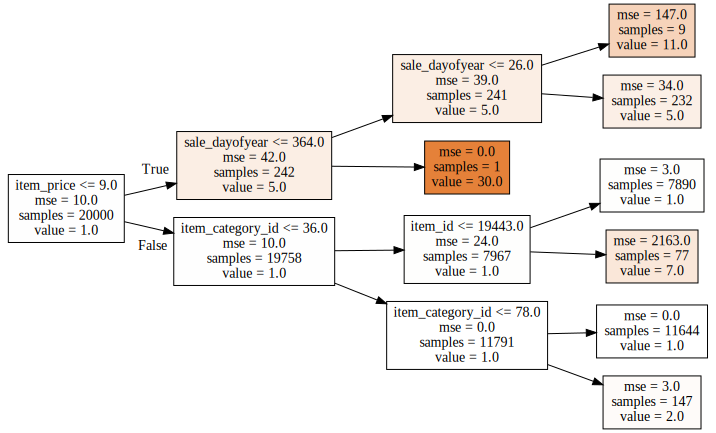

In [48]:
draw_tree(m.estimators_[0] , df_base)